In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
sns.set_style('whitegrid')
from datetime import timedelta
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load the Data and Explore

In [3]:
df = pd.read_csv('geyser_dataset.csv')

In [4]:
len(df)

34842

In [5]:
df.info() # no missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34842 entries, 0 to 34841
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time_index             34842 non-null  object 
 1   Internal temperature   34842 non-null  float64
 2   Inlet temperature      34842 non-null  float64
 3   Outlet temperature     34842 non-null  float64
 4   Ambient temperature    34842 non-null  float64
 5   Energy consumed        34842 non-null  float64
 6   Volume of water drawn  34842 non-null  float64
 7   Water flow             34842 non-null  bool   
dtypes: bool(1), float64(6), object(1)
memory usage: 1.9+ MB


In [6]:
df.head()

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow
0,2020-10-03 00:03:25+02:00,52.66,15.66,47.93,16.02,0.0,0.0,False
1,2020-10-03 00:08:21+02:00,52.55,15.64,48.24,15.94,0.0,0.0,False
2,2020-10-03 00:13:23+02:00,52.37,15.53,47.93,15.92,0.0,0.0,False
3,2020-10-03 00:18:25+02:00,52.37,15.51,47.89,15.92,0.0,0.0,False
4,2020-10-03 00:23:21+02:00,52.37,15.46,47.82,15.84,0.0,0.0,False


In [7]:
df.tail()

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow
34837,2021-01-31 23:38:25+02:00,37.47,23.69,44.29,22.86,0.0,0.0,False
34838,2021-01-31 23:43:22+02:00,37.58,23.46,43.96,22.60,0.0,0.0,False
34839,2021-01-31 23:48:23+02:00,37.67,23.23,43.54,22.39,0.0,0.0,False
34840,2021-01-31 23:53:25+02:00,37.73,23.05,43.12,22.39,0.0,0.0,False
34841,2021-01-31 23:58:22+02:00,37.88,22.89,42.93,22.15,0.0,0.0,False


# Data Preprocessing and Feature Engineering

In [8]:
# Convert time_index feature from a string to a datetime object 
df['time_index'] = pd.to_datetime(df['time_index'])
# df_cont is a dataframe with rows only where Water flow is True
df_cont = (df[df['Water flow'] == True])

Now, we need to extract only the consecutive measurements where Water flow is true. We can leverage the index here such that only consecutive indices are extracted. 

In [9]:
df_cont.head(5)

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow
96,2020-10-03 08:03:24+02:00,46.23,15.82,47.51,16.76,0.00,40.0,True
97,2020-10-03 08:08:25+02:00,45.56,16.23,47.82,16.89,0.00,40.0,True
98,2020-10-03 08:13:22+02:00,47.55,16.53,47.96,17.23,259.64,40.0,True
99,2020-10-03 08:18:23+02:00,50.03,16.64,46.63,17.35,268.66,10.0,True
115,2020-10-03 09:38:24+02:00,60.13,20.43,51.59,21.35,0.00,5.0,True


In [10]:
len(df_cont)

3271

Now, the goal is to successfully group together consecutive blocks so that each individual water draw event is a row

In [11]:
df_cont['Block Number'] = df_cont.index.to_series().diff().ne(1).cumsum()
df_cont.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Internal temperature,3271.0,47.040165,11.359769,16.84,39.375,50.07,56.44,62.81
Inlet temperature,3271.0,25.189386,4.670745,12.23,21.760,25.00,27.68,45.66
Outlet temperature,3271.0,53.481076,5.867079,28.29,50.670,54.80,57.91,63.19
Ambient temperature,3271.0,26.506139,5.297373,11.58,22.600,26.18,30.28,44.19
Energy consumed,3271.0,51.001902,102.761266,0.00,0.000,0.00,0.00,326.89
Volume of water drawn,3271.0,53.778661,72.375266,5.00,5.000,20.00,70.00,435.00
Block Number,3271.0,963.058698,536.587175,1.00,505.500,978.00,1443.50,1844.00


In [12]:
df_final = df_cont.groupby('Block Number').mean()

In [13]:
df_final

,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow
Block Number,,,,,,,
1,47.342500,16.305000,47.480000,17.057500,132.075,32.500000,1.0
2,60.130000,20.430000,51.590000,21.350000,0.000,5.000000,1.0
3,31.955714,18.520000,54.010000,21.311429,0.000,165.000000,1.0
4,16.920000,20.230000,46.730000,21.480000,0.000,5.000000,1.0
5,17.020000,22.310000,45.540000,22.720000,0.000,5.000000,1.0
...,...,...,...,...,...,...,...
1840,31.210000,29.750000,52.850000,32.250000,0.010,25.000000,1.0
1841,33.020000,28.700000,52.880000,31.975000,130.100,22.500000,1.0
1842,57.120000,30.860000,53.380000,31.290000,0.000,5.000000,1.0


**Generating Relevant Features:** Seeing that consecutive individual 5 minute measurements where water is being drawn are lumped together, aggregations can be used to generate relevant features. The maximum, minimum, average and range of the temperature and energy data was used to generate features. In addition, the following features were generated:

1. Hour of day
2. Day of event
3. Month of event 
4. Average temperature change
5. Average rate of change of temperature 

Also, the target variable is the Cumulative volume of water drawn (for each event)

In [14]:
df_final['Cumulative energy consumed'] = df_cont.groupby('Block Number').sum()['Energy consumed']
df_final['Cumulative volume of water drawn'] = df_cont.groupby('Block Number').sum()['Volume of water drawn']
df_final.rename(columns={'Internal temperature': 'Average internal temperature',
                        'Inlet temperature': 'Average inlet temperature',
                        'Outlet temperature': 'Average outlet temperature',
                        'Ambient temperature':'Average ambient temperature',
                        'Energy consumed':'Average energy consumed',
                        'Volume of water drawn':'Average volume of water drawn'}, inplace=True)
df_final = df_final.drop('Average volume of water drawn',axis=1)

In [15]:
df_final['min internal temp'] = df_cont.groupby('Block Number').min()['Internal temperature']
df_final['min inlet temp'] = df_cont.groupby('Block Number').min()['Inlet temperature']
df_final['min outlet temp'] = df_cont.groupby('Block Number').min()['Outlet temperature']
df_final['min ambient temp'] = df_cont.groupby('Block Number').min()['Ambient temperature']
df_final['min energy consumed'] = df_cont.groupby('Block Number').min()['Energy consumed']

df_final['max internal temp'] = df_cont.groupby('Block Number').max()['Internal temperature']
df_final['max inlet temp'] = df_cont.groupby('Block Number').max()['Inlet temperature']
df_final['max outlet temp'] = df_cont.groupby('Block Number').max()['Outlet temperature']
df_final['max ambient temp'] = df_cont.groupby('Block Number').max()['Ambient temperature']
df_final['max energy consumed'] = df_cont.groupby('Block Number').max()['Energy consumed']

# df_final['std internal temp'] = df_cont.groupby('Block Number').std()['Internal temperature']
# df_final['std inlet temp'] = df_cont.groupby('Block Number').std()['Inlet temperature']
# df_final['std outlet temp'] = df_cont.groupby('Block Number').std()['Outlet temperature']
# df_final['std ambient temp'] = df_cont.groupby('Block Number').std()['Ambient temperature']
# df_final['std energy consumed'] = df_cont.groupby('Block Number').std()['Energy consumed']

df_final['rng internal temp'] = df_final['max internal temp'] - df_final['min internal temp']
df_final['rng inlet temp'] = df_final['max inlet temp'] - df_final['min inlet temp']
df_final['rng outlet temp'] = df_final['max outlet temp'] - df_final['min outlet temp']
df_final['rng ambient temp'] = df_final['max ambient temp'] - df_final['min ambient temp']
df_final['rng energy consumed'] = df_final['max energy consumed'] - df_final['min energy consumed']

df_final['number of recordings'] = df_cont.groupby('Block Number').size().values


In [16]:
df_final['Event start time'] = df_cont[df_cont.index.to_series().diff().ne(1) == True]['time_index'].to_frame().reset_index().set_index(df_final.index)['time_index']
event_start_index = df_cont[df_cont.index.to_series().diff().ne(1) == True].index
event_end_index = []
for idx in event_start_index:
    if idx == event_start_index[0]:
        continue
    itemindex = np.where(df_cont.index == idx)
    event_end_index.append(df_cont.index[itemindex[0][0]-1])
event_end_index.append(df_cont.index[-1])
df_final['Event end time'] = df_cont.loc[event_end_index]['time_index'].to_frame().reset_index().set_index(df_final.index)['time_index']

t = (df_final['Event end time'] - df_final['Event start time']) + timedelta(minutes=5)
Elapsed_time = []
for time in t:
    Elapsed_time.append(time.total_seconds() / 3600)
    
df_final['Elapsed time'] = Elapsed_time
df_final['Power'] = df_final['Cumulative energy consumed'] / df_final['Elapsed time']

df_final['Hour of day'] = df_final['Event start time'].apply(lambda x:x.hour)
df_final['Day of event'] = df_final['Event start time'].apply(lambda x:x.day)
df_final['Month of event'] = df_final['Event start time'].apply(lambda x:x.month)
df_final['Average temp change'] = df_final['Average outlet temperature'] - df_final['Average inlet temperature']
df_final['Average rate of temp change'] = df_final['Average temp change'] / df_final['Elapsed time']

In [17]:
df_final.drop('Water flow',axis=1).corr()['Cumulative volume of water drawn'].sort_values(key=abs,ascending=False)

Cumulative volume of water drawn    1.000000
rng internal temp                   0.897935
rng outlet temp                     0.693622
Average rate of temp change        -0.573210
rng ambient temp                    0.542910
Elapsed time                        0.506286
number of recordings                0.505479
min internal temp                  -0.495808
rng energy consumed                 0.405066
Cumulative energy consumed          0.404695
rng inlet temp                      0.300399
Average internal temperature       -0.297856
max energy consumed                 0.239915
Average temp change                 0.209536
min inlet temp                     -0.181124
max outlet temp                     0.161538
Average energy consumed             0.157381
Power                               0.157274
Average inlet temperature          -0.154043
min ambient temp                   -0.129459
max inlet temp                     -0.104910
Average ambient temperature        -0.089178
Average ou

In [18]:
df_final.head(5)

,Average internal temperature,Average inlet temperature,Average outlet temperature,Average ambient temperature,Average energy consumed,Water flow,Cumulative energy consumed,Cumulative volume of water drawn,min internal temp,min inlet temp,...,number of recordings,Event start time,Event end time,Elapsed time,Power,Hour of day,Day of event,Month of event,Average temp change,Average rate of temp change
Block Number,,,,,,,,,,,,,,,,,,,,,
1,47.342500,16.305,47.48,17.057500,132.075,1.0,528.3,130.0,45.56,15.82,...,4,2020-10-03 08:03:24+02:00,2020-10-03 08:18:23+02:00,0.333056,1586.221852,8,3,10,31.175,93.603003
2,60.130000,20.430,51.59,21.350000,0.000,1.0,0.0,5.0,60.13,20.43,...,1,2020-10-03 09:38:24+02:00,2020-10-03 09:38:24+02:00,0.083333,0.000000,9,3,10,31.160,373.920000
3,31.955714,18.520,54.01,21.311429,0.000,1.0,0.0,1155.0,16.84,17.43,...,7,2020-10-03 10:18:22+02:00,2020-10-03 10:48:22+02:00,0.583333,0.000000,10,3,10,35.490,60.840000
4,16.920000,20.230,46.73,21.480000,0.000,1.0,0.0,5.0,16.92,20.23,...,1,2020-10-03 10:58:25+02:00,2020-10-03 10:58:25+02:00,0.083333,0.000000,10,3,10,26.500,318.000000
5,17.020000,22.310,45.54,22.720000,0.000,1.0,0.0,10.0,17.02,22.26,...,2,2020-10-03 11:13:25+02:00,2020-10-03 11:18:21+02:00,0.165556,0.000000,11,3,10,23.230,140.315436


Text(0.5, 1.0, 'Correlation Matrix')

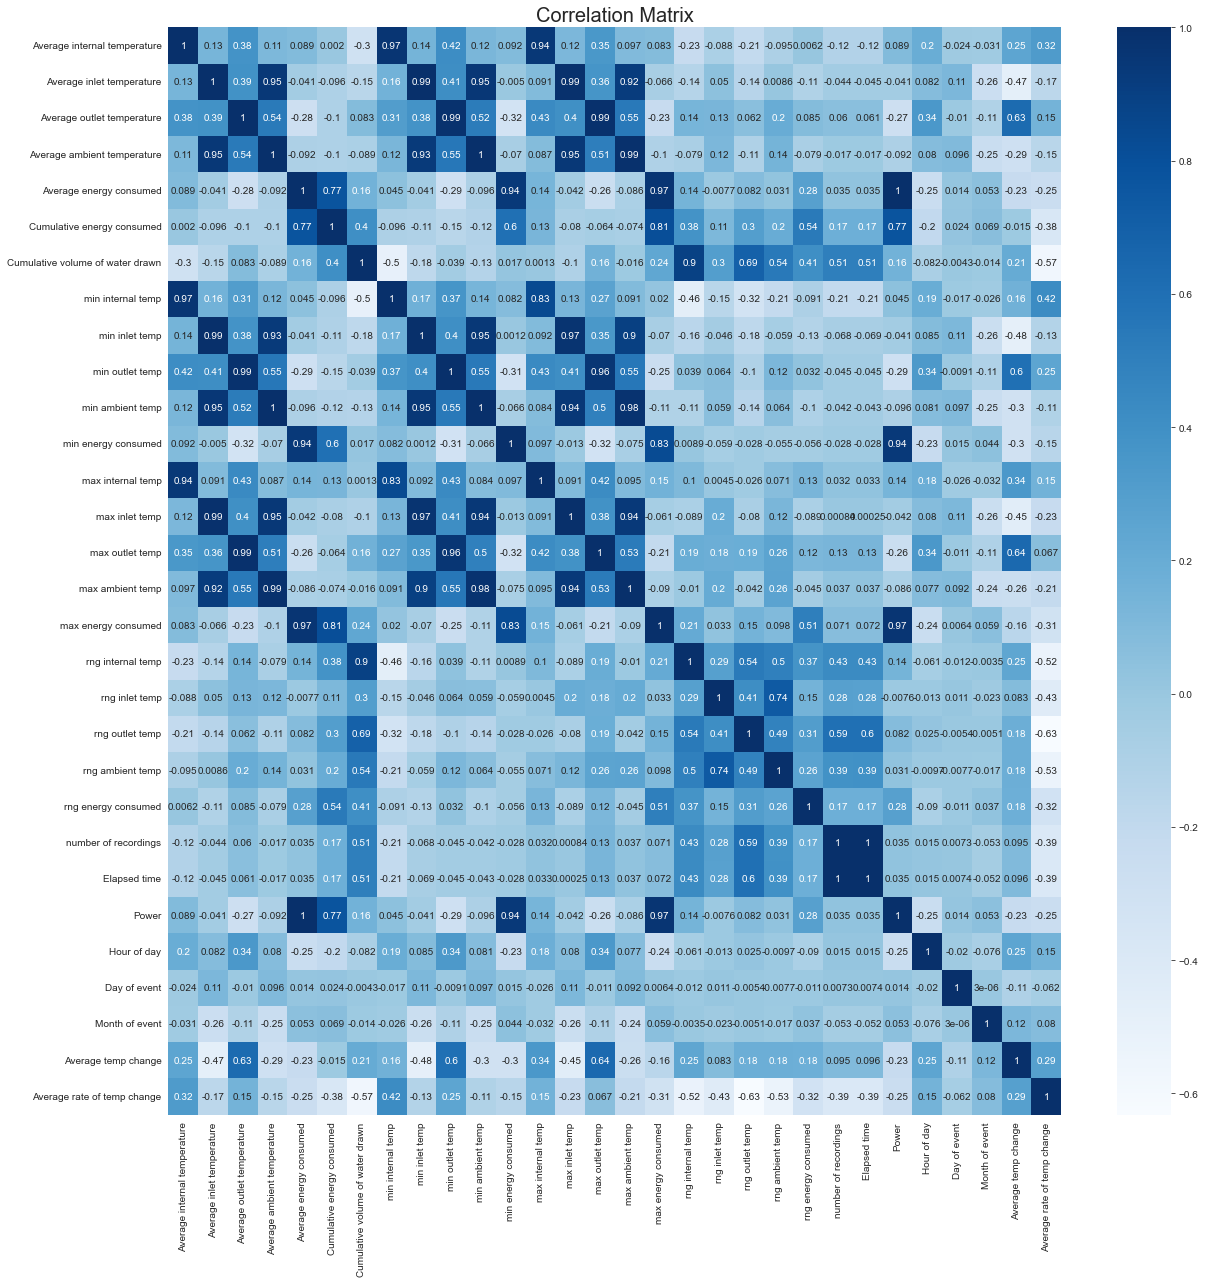

In [19]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(df_final.drop('Water flow',axis=1).corr(), annot = True, cmap = 'Blues')
ax.set_title("Correlation Matrix",fontsize=20)

In [20]:
corr_target = df_final.corr()['Cumulative volume of water drawn']
def correlation(data, threshold):
    """
    Input: Dataframe and threshold
    Output: Returns a set of correlated features such that these features have a correlation greater than the
    specified threshold with at least one other independent feature 
    """
    corr_col = set()
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                rowname = corr_matrix.index[j]
                if abs(corr_target[colname]) < abs(corr_target[rowname]):
                    corr_col.add(colname)
                else:
                    corr_col.add(rowname)
                
    return corr_col

In [21]:
corr_features = correlation(df_final.drop(['Water flow','Cumulative volume of water drawn'],axis=1), 0.85)
# corr_features.remove('min internal temp')
# corr_features.add('Average internal temperature')
df_final = df_final.drop(corr_features,axis = 1)

In [22]:
corr_features

{'Average ambient temperature',
 'Average energy consumed',
 'Average inlet temperature',
 'Average internal temperature',
 'Average outlet temperature',
 'Power',
 'max ambient temp',
 'max inlet temp',
 'max internal temp',
 'min ambient temp',
 'min energy consumed',
 'min outlet temp',
 'number of recordings'}

In [23]:
df_final.drop(['Water flow','Cumulative volume of water drawn'],axis=1).corr()[abs(df_final.drop(['Water flow','Cumulative volume of water drawn'],axis=1).corr()) >= 0.85].dropna(thresh=2)
# No independent variables with absolute correlations greater than 0.85

,Cumulative energy consumed,min internal temp,min inlet temp,max outlet temp,max energy consumed,rng internal temp,rng inlet temp,rng outlet temp,rng ambient temp,rng energy consumed,Elapsed time,Hour of day,Day of event,Month of event,Average temp change,Average rate of temp change


In [24]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844 entries, 1 to 1844
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype                                
---  ------                            --------------  -----                                
 0   Water flow                        1844 non-null   float64                              
 1   Cumulative energy consumed        1844 non-null   float64                              
 2   Cumulative volume of water drawn  1844 non-null   float64                              
 3   min internal temp                 1844 non-null   float64                              
 4   min inlet temp                    1844 non-null   float64                              
 5   max outlet temp                   1844 non-null   float64                              
 6   max energy consumed               1844 non-null   float64                              
 7   rng internal temp                 1844 non-null   f

# Exploratory Data Analysis and Inference

### Variation of the target variable over time

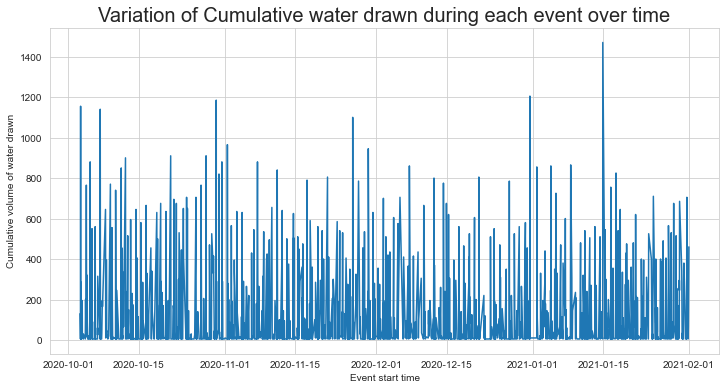

In [25]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(x='Event start time',y='Cumulative volume of water drawn', data=df_final,linewidth=1.5)
ax.set_title('Variation of Cumulative water drawn during each event over time',fontsize=20)
plt.show()

**Inference:** For the most part, the variation over the 4 months seems to be quite consistent, with abrupt surges that should be further explored. Assuming that this data is from South Africa, the temperature should be rising from October to February, and this is evident from the above plot, as the plot is more dense earlier indicating greater amounts of hot water being drawn by consumers in the colder months. 

### Distribution of the target variable 

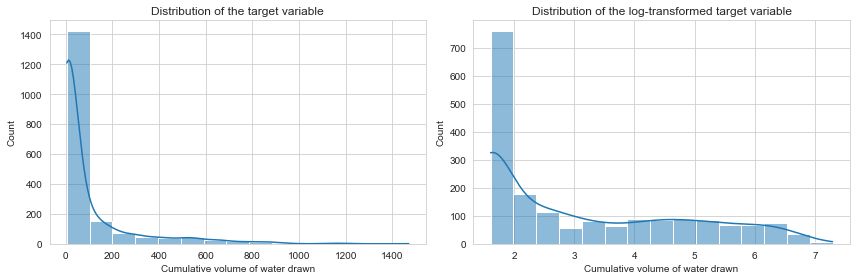

In [26]:
num_bins = 15
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,4))
ax2 = sns.histplot(data = df_final, x = np.log(df_final["Cumulative volume of water drawn"]), bins = num_bins,kde=True,ax=ax2)
ax1 = sns.histplot(data = df_final, x = df_final["Cumulative volume of water drawn"], bins = num_bins,kde=True,ax=ax1)
ax1.set_title("Distribution of the target variable")
ax2.set_title("Distribution of the log-transformed target variable")
plt.tight_layout() 

**Inference:** The distribution of the target variable (cumulative volume of water drawn) is heavily positively skewed (skew = 1.45). In order to ensure that the distribution of the target variable is closer to that of a nomral distribution, the log transform can be taken. When the log transform is taken, it seems to be a bimodal distribution and is not convincingly transformed into a normal distribution as seen above. Box-Cox transformation and square root transformation were also explored, but the best fit seemed to be the log transform. 

In [27]:
df_final.agg(['skew'])['Cumulative volume of water drawn']

skew    2.858853
Name: Cumulative volume of water drawn, dtype: float64

### Relationships between the numerical features and the target variable

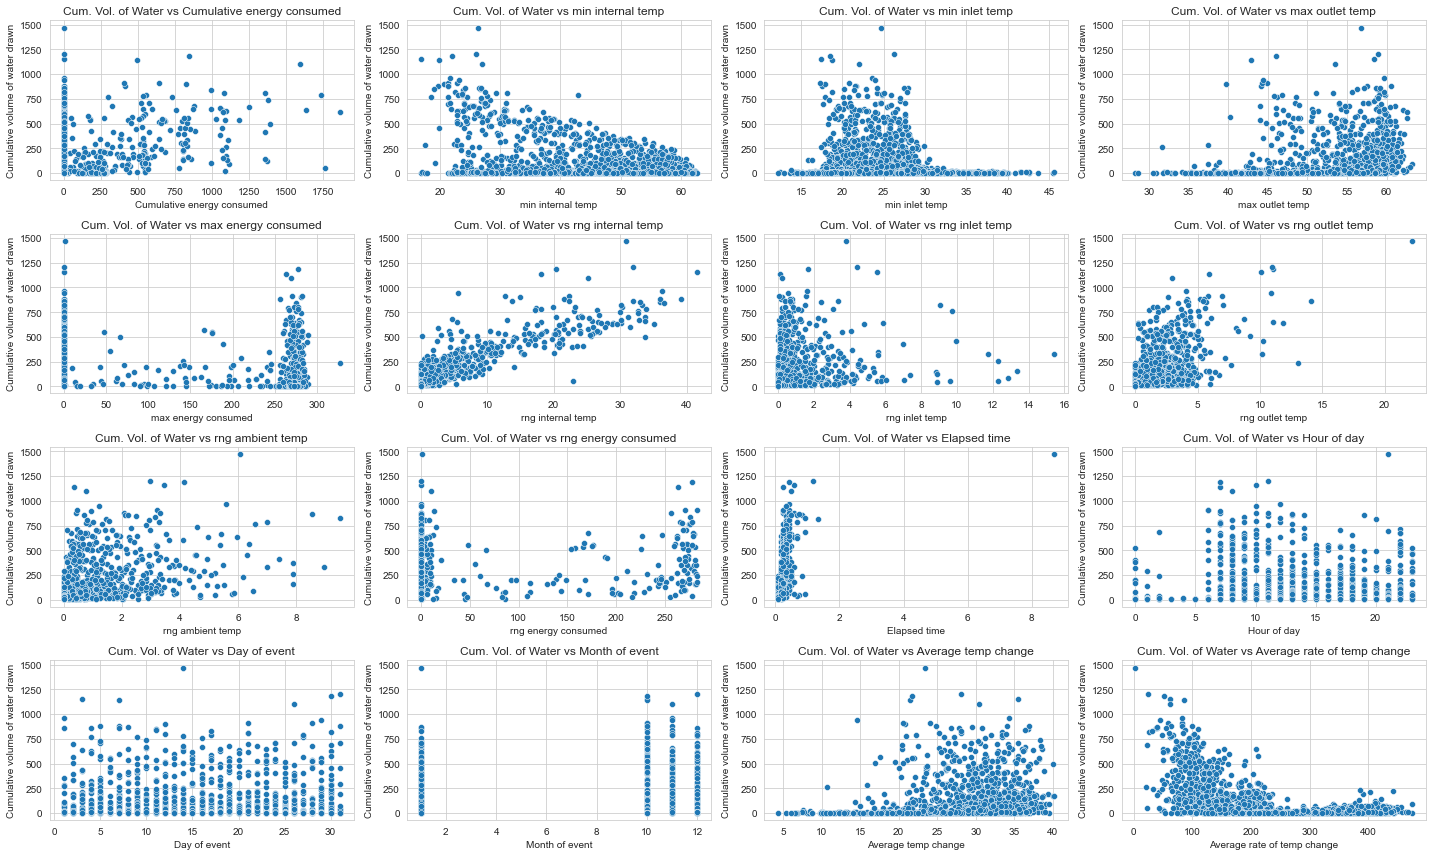

In [28]:
numeric_cols = df_final.select_dtypes(include=['float','int']).dtypes
numeric_cols = numeric_cols.drop(labels=['Water flow','Cumulative volume of water drawn'])
numeric_features = list(numeric_cols.index)

COL_NUM = 4
ROW_NUM = 4

fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,12))
for i, feature in enumerate(numeric_features): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    sns.scatterplot(data = df_final, x = feature, y = "Cumulative volume of water drawn", ax=ax)
    ax.set_xlabel(f"{feature}")
    ax.set_ylabel("Cumulative volume of water drawn")
    ax.set_title(f"Cum. Vol. of Water vs {feature}")

plt.tight_layout() 

**Inference:** 
1. There seems to be an **extreme outlier**, where the elapsed time of the particular event is more than 8 hours. To provide some context, the rest of the events are less than 2 hours. This data point will be dropped although it is not clear if this data point is in fact erroneous. However, droping this outlier will improve performance of regression based models, which are not robust to outliers. 
2. Cumulative energy consumed and Power are sparse features. Typically, learning algorithms do not learn well from sparse data. However, XGBoost does so it is worth exploring.
3. The temperature-based features are rather skewed so it makes sense to scale the feature matrix
4. Hour of day, Day of event and Month of event are all discrete features. Perhaps we can one-hot encode these discrete features at the expense of increasing model complexity. Feature selection techniques can be used to handle model complexity. However, it is clear from the correlation matrix that Day of event and Month of event has almost zero correlation with the target variable. It makes sense to simply drop these two features.
5. As expected, there tends to be a greater demand for hot water in the morning, which drops later in the day, and picks up in the late evening.

### Hot water demand over the course of the day

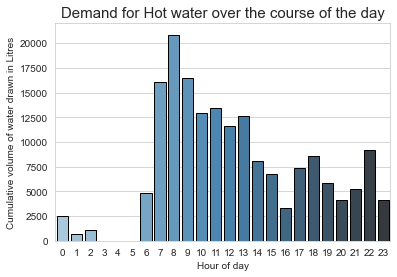

In [29]:
hour_df = df_final.groupby('Hour of day').sum()
ax = sns.barplot(x=hour_df.index, y="Cumulative volume of water drawn", data=hour_df, palette="Blues_d", \
                 linewidth=1,edgecolor = 'k')
ax.set_title('Demand for Hot water over the course of the day',fontsize=15)
ax.set_ylabel("Cumulative volume of water drawn in Litres")
plt.ylim((0,22000))
plt.show()

**Inference:** As expected, there is a greater demand for hot water in the morning, which gradually decreases and picks up moderaately in the late evenings. Lowest demand seems to befrom 12 AM - 2 AM. One thing to note here is that there is no sensor data between the hours of 3 AM and 5 AM, which is worth exploring. Is there absolutely no hot water being drawn during these hours (unlikely) or are there no sensor measurements during this time? Ideally, sensor measurements should be recoreded always but the cost of collecting this data may be rather expensive, which may be why the sensor is turned off during the hours where the expected demand for hot water is relatively lower. 

In [30]:
# df_final['Hour of day'] = df_final['Hour of day'].astype('category')
# one_hot_encode = pd.get_dummies(df_final['Hour of day'], drop_first=True)
# df_final = df_final.drop('Hour of day',axis=1)
# df_final = pd.concat([df_final, one_hot_encode], axis = 1)

### Dealing with Outliers

As mentioned above, the extreme outlier is removed from the data. Visually, this was the one outlier that was highly apparent. Seeing that there is already not much data to begin with, just this one point is dropped from the dataset. 

In [31]:
# df_final[df_final['number of recordings'] > 20]
df_final[df_final['Elapsed time'] > 2]

,Water flow,Cumulative energy consumed,Cumulative volume of water drawn,min internal temp,min inlet temp,max outlet temp,max energy consumed,rng internal temp,rng inlet temp,rng outlet temp,rng ambient temp,rng energy consumed,Event start time,Event end time,Elapsed time,Hour of day,Day of event,Month of event,Average temp change,Average rate of temp change
Block Number,,,,,,,,,,,,,,,,,,,,
1587,1.0,1.25,1470.0,26.34,24.68,56.76,1.24,30.86,3.77,22.18,6.08,1.24,2021-01-14 21:38:22+02:00,2021-01-15 06:16:14+02:00,8.714444,21,14,1,23.352381,2.679733


In [32]:
# df_final = df_final[df_final['number of recordings'] <= 20] 
df_final = df_final[df_final['Elapsed time'] <= 2] 
df_final = df_final.drop(['Day of event','Month of event'],axis=1)

# Model Selection

We will be incorporating the supervised learning framework to predict the cumulative volume of water drawn in each water draw event, which is defined as an event where there is continuous flow of water / all consecutive measurements where Water flow is True.

## Training - Validation Split and Feature Scaling

Since we are dealing with data indexed with a time order (time-series data), we cannot split the data at random, as this would lead to data leakage. For example, we may be using data from the future to forecast the past if the data from the future is in our training set, and the past data is in our test set. Therefore, it is wise to incorporate structured splitting after the entire dataset is sorted in increasing order by time to ensure that we are only using data from the past to forecast the future. There is a temporal dependency between observations, and we must preserve that relation during testing.

Also, seeing that a separate test dataset is provided, this entire current dataset can be considered as our development dataset. Therefore, this dataset should only be split into a training dataset and a validation dataset for the purposes of hyperparameter tuning and model selection. 80% of the data will be used for training purposes and the remaining 20% of tbe data will be used as the validation dataset. 

In [33]:
# Using a 4:1 train/validation split
len(df_final) * 0.8

1474.4

In [34]:
df_train = df_final[:1474]
df_val = df_final[1474:]

X_train = df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
y_train = df_train['Cumulative volume of water drawn']

X_val = df_val.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
y_val = df_val['Cumulative volume of water drawn']

# Standardize the columns in the feature matrices to have zero mean and unit variance 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

In [35]:
df_final.to_csv("geyser_dataset_aggregated.csv")

In [36]:
# # Log transforming the target variable
# df_final['Cumulative volume of water drawn'] = np.log(df_final["Cumulative volume of water drawn"])

## Baseline Model

As a baseline model, the mean of the training labels (y_train) is used as the prediction for all instances. This is a common baseline used in regression problems and tells you if the model is any good. Your model MSEs should be much lower than these baseline MSEs.

In [37]:
from sklearn.metrics import mean_squared_error
print(f"Baseline Mean-squared error on Training set (Baseline): {mean_squared_error(y_train,(np.mean(y_train)*np.ones_like(y_train)))}")
print(f"Baseline Mean-squared error on Validation set (Baseline): {mean_squared_error(y_val,(np.mean(y_train)*np.ones_like(y_val)))}")
baseline_MSE_val = mean_squared_error(y_val,(np.mean(y_train)*np.ones_like(y_val)))
print(f"Adjusted R^2 score on Validation set (Baseline): {0}")

Baseline Mean-squared error on Training set (Baseline): 33471.572797784844
Baseline Mean-squared error on Validation set (Baseline): 27153.042209220035
Adjusted R^2 score on Validation set (Baseline): 0


## Linear Regression 

In [38]:
# Train a linear regression model using all the numerical features in the dataset
from sklearn import linear_model
linreg_m = linear_model.LinearRegression()
linreg_m.fit(X_train, y_train)
y_pred_val_linreg = linreg_m.predict(X_val)
y_pred_train_linreg = linreg_m.predict(X_train)

In [39]:
# Evaluating feature importances 
coeffecients = pd.DataFrame(np.append(linreg_m.intercept_,linreg_m.coef_),np.append('Bias Term',df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1).columns))
coeffecients.columns = ['Coefficient']
coeffecients.round(2).sort_values(by='Coefficient',key=abs,ascending=False)

,Coefficient
rng internal temp,119.86
Bias Term,95.03
rng outlet temp,54.63
Average temp change,-31.50
rng ambient temp,28.70
rng inlet temp,-24.51
Average rate of temp change,23.71
max outlet temp,20.14
min internal temp,-18.06
min inlet temp,-16.18


Text(0.5, 1.0, 'Linear Regression - Feature Importances')

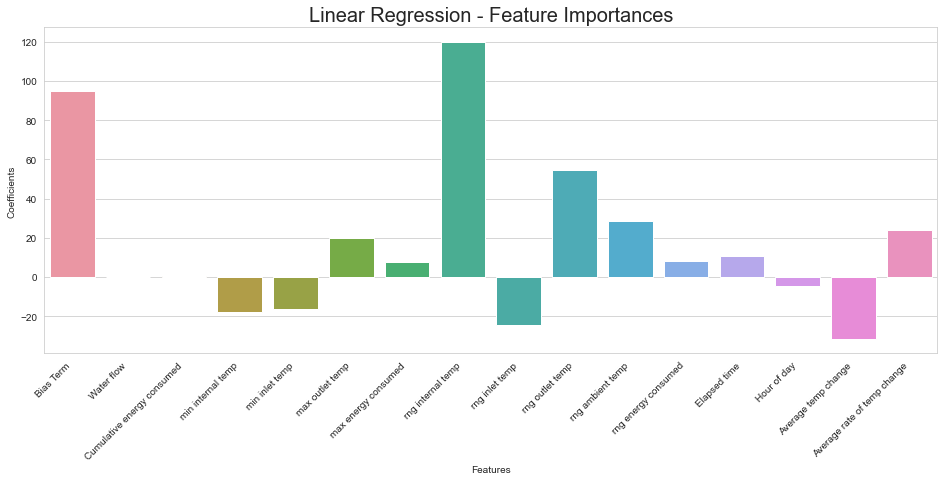

In [40]:
features = np.append('Bias Term',df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1).columns)
fig = plt.figure(figsize = (16,6))
ax = sns.barplot(x=features,y=coeffecients['Coefficient'].values)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel("Features")
ax.set_ylabel("Coefficients")
ax.set_title("Linear Regression - Feature Importances",fontsize = 20)

In [41]:
print(f"Mean-squared error on Training set (Linear Regression): {mean_squared_error(y_train,y_pred_train_linreg)}")
print(f"Mean-squared error on Validation set (Linear Regression): {mean_squared_error(y_val,y_pred_val_linreg)}")
linreg_MSE_val = mean_squared_error(y_val,y_pred_val_linreg)
linreg_R2 = linreg_m.score(X_val, y_val)
n = len(X_train)
p = len(X_train[0])
linreg_adj_R2 = 1- ((1-linreg_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (Linear Regression): {round(linreg_adj_R2,3)}")

Mean-squared error on Training set (Linear Regression): 3821.7714851897103
Mean-squared error on Validation set (Linear Regression): 3544.8320998233066
Adjusted R^2 score on Validation set (Linear Regression): 0.868


**Conclusion** The linear regression model significantly outperforms the baseline model as expected. The relatively low difference between the training and validation error indicates that the model is not overfitting. Perhaps the bias can be further reduced at the cost of increasing variance so that the model learns better from the training data. 

## Lasso Regression

In [42]:
lassoreg_m = linear_model.Lasso()
lassoreg_m.fit(X_train, y_train)
y_pred_lasso_val=lassoreg_m.predict(X_val)
y_pred_lasso_train = lassoreg_m.predict(X_train)

Evaluate the vanilla Lasso regression model without hyperparameter tuning

In [43]:
print(f"Mean-squared error on Training set (Lasso Regression): {mean_squared_error(y_train,y_pred_lasso_train)}")
print(f"Mean-squared error on Validation set (Lasso Regression): {mean_squared_error(y_val,y_pred_lasso_val)}")
vanilla_lassoreg_MSE_val = mean_squared_error(y_val,y_pred_lasso_val)
lassoreg_R2 = lassoreg_m.score(X_val, y_val)
n = len(X_train)
p = len(X_train[0])
lassoreg_adj_R2 = 1- ((1-lassoreg_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (Lasso Regression): {round(lassoreg_adj_R2,3)}")

Mean-squared error on Training set (Lasso Regression): 3866.0864615239548
Mean-squared error on Validation set (Lasso Regression): 3514.9789356340643
Adjusted R^2 score on Validation set (Lasso Regression): 0.869


We can tune the hyperparameter alpha, which is the L1 regularization hyperparameter. Typically, the higher the alpha, the fewer the number of non-zero coefficients. 
Instead of regular k-fold cross validation, time series splits are used to ensure that there is no data leakage (predicting the past using future data). Two criteria are met here: every validation set contains unique observations and observations from the training set occur before their corresponding validation set.

In [44]:
# Hyperparameter tuning
val_scores = []

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 3)

alphas = np.linspace(0.01,20,1000)
for alpha_val in alphas:
    cv_scores = []
    for train_index, val_index in tscv.split(df_final):
        cv_train, cv_val = df_final.iloc[train_index], df_final.iloc[val_index]
        X_cv_train = cv_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
        y_cv_train = cv_train['Cumulative volume of water drawn']
        X_cv_val = cv_val.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
        y_cv_val = cv_val['Cumulative volume of water drawn']
        lassoreg_m = linear_model.Lasso(alpha=alpha_val)
        lassoreg_m.fit(X_cv_train, y_cv_train)
        y_pred_lasso_val=lassoreg_m.predict(X_cv_val)
        cv_scores.append(mean_squared_error(y_cv_val,y_pred_lasso_val))
    val_scores.append((alpha_val,np.mean(cv_scores)))

In [45]:
val_scores.sort(key = lambda y:y[1])
print(f"The optimal alpha value is: {round(val_scores[0][0],2)}")

The optimal alpha value is: 0.75


In [46]:
lassoreg_best = linear_model.Lasso(alpha=val_scores[0][0])
lassoreg_best.fit(X_train, y_train)
y_pred_lasso_val=lassoreg_best.predict(X_val)
y_pred_lasso_train = lassoreg_best.predict(X_train)
print(f"The optimal Mean-squared error on Validation set (Lasso Regression): {round(mean_squared_error(y_val,y_pred_lasso_val),2)}")
lassoreg_MSE_val = mean_squared_error(y_val,y_pred_lasso_val)

The optimal Mean-squared error on Validation set (Lasso Regression): 3519.56


In [47]:
coeffecients = pd.DataFrame(np.append(lassoreg_best.intercept_,lassoreg_best.coef_),np.append('Bias Term',df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1).columns))
coeffecients.columns = ['Coefficient']
coeffecients.sort_values(by='Coefficient', key=abs,ascending=False)

,Coefficient
rng internal temp,119.639963
Bias Term,95.033921
rng outlet temp,54.178371
rng ambient temp,24.178920
rng inlet temp,-19.697360
min internal temp,-17.118080
Average rate of temp change,13.748412
rng energy consumed,7.126760
max energy consumed,6.206083
Elapsed time,5.693936


In [48]:
print(f"Percentage decrease in validation MSE after hyperparameter tuning: {round(((vanilla_lassoreg_MSE_val - lassoreg_MSE_val) / vanilla_lassoreg_MSE_val) * 100,2)}%")

Percentage decrease in validation MSE after hyperparameter tuning: -0.13%


#### Feature selection using lasso regression
One way of doing feature selection is to train a lasso regression model, and choose the features with the highest absolute coefficients. This is especially useful as a variance reduction technique, as choosing fewer features reduces model complexity

In [49]:
print("Top 5 features from the lasso regression model in terms of absolute coefficients \n")
top_5coeff_lasso = []
for i in coeffecients.sort_values(by='Coefficient', key=abs,ascending=False).index[:6]:
    if i == "Bias Term":
        continue
    print(i)
    top_5coeff_lasso.append(i)

Top 5 features from the lasso regression model in terms of absolute coefficients 

rng internal temp
rng outlet temp
rng ambient temp
rng inlet temp
min internal temp


## Decision Tree

In [50]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
dtree_m = DecisionTreeRegressor()
dtree_m.fit(X_train, y_train)
y_pred_dtree_train = dtree_m.predict(X_train)
y_pred_dtree_val= dtree_m.predict(X_val)

print(f"Mean-squared error on Training set (Decision Tree): {mean_squared_error(y_train,y_pred_dtree_train)}")
print(f"Mean-squared error on Validation set (Decision Tree): {mean_squared_error(y_val,y_pred_dtree_val)}")
dtree_MSE_val = mean_squared_error(y_val,y_pred_dtree_val)
dtree_R2 = dtree_m.score(X_val, y_val)
n = len(X_train)
p = len(X_train[0])
dtree_adj_R2 = 1- ((1-dtree_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (Decision Tree): {round(dtree_adj_R2,3)}")

Mean-squared error on Training set (Decision Tree): 0.0
Mean-squared error on Validation set (Decision Tree): 5912.804878048781
Adjusted R^2 score on Validation set (Decision Tree): 0.78


Text(0.5, 1.0, 'Feature Importances for the Decision Tree Model')

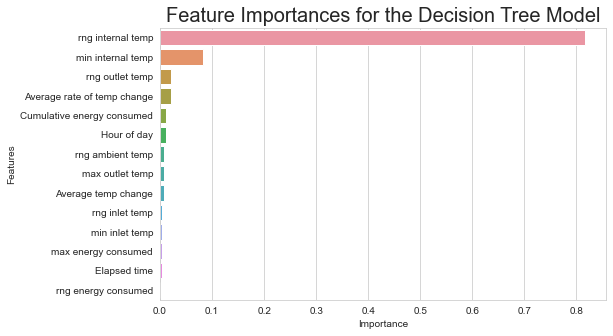

In [51]:
fig = plt.figure(figsize = (8,5))
feature_names = [key for key in df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)]
feat_imps = list(zip(feature_names,dtree_m.feature_importances_))
feats, imps = zip(*(sorted(list(filter(lambda x:x[1] != 0, feat_imps)), key=lambda x:x[1],reverse=True)))
ax = sns.barplot(x = list(imps[:]), y = list(feats[:]))
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
ax.set_title("Feature Importances for the Decision Tree Model",fontsize=20)

In [52]:
print("Top 5 features from the Vanilla Random Forest model \n")
for i in list(feats[:5]):
    print(i)

Top 5 features from the Vanilla Random Forest model 

rng internal temp
min internal temp
rng outlet temp
Average rate of temp change
Cumulative energy consumed


Since ensemble techniques outperform a decision tree, it is not worthwhile to hyperparameter tune for a decision tree model. However, a decision tree is more interpretable than an ensemble method such as a randomforest model, so there is value in training a decision tree to plot the feature importances.

## Random Forest Regressor Model

In [53]:
from sklearn.ensemble import RandomForestRegressor
rforest_m = RandomForestRegressor()
rforest_m.fit(X_train, y_train)
y_pred_rforest_train = rforest_m.predict(X_train)
y_pred_rforest_val= rforest_m.predict(X_val)

In [54]:
print(f"Mean-squared error on Training set (Random Forest): {mean_squared_error(y_train,y_pred_rforest_train)}")
print(f"Mean-squared error on Validation set (Random Forest): {mean_squared_error(y_val,y_pred_rforest_val)}")
vanillaRF_MSE_val = mean_squared_error(y_val,y_pred_rforest_val)
rforest_R2 = rforest_m.score(X_val, y_val)
n = len(X_train)
p = len(X_train[0])
rforest_adj_R2 = 1- ((1-rforest_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (Random Forest): {round(rforest_adj_R2,3)}")

Mean-squared error on Training set (Random Forest): 433.81613805970153
Mean-squared error on Validation set (Random Forest): 2865.996287262873
Adjusted R^2 score on Validation set (Random Forest): 0.893


The siginificant difference between the training error and validation error indicates that this model is overfitting to the training data. Hyperparameter tuning can be performed to imporve validation performance using variance reduction techniques specific to tree-based algorithms such as controlling the max_depth of each individudal tree as well as controlling the maximum number of features to consider at each split.

Text(0.5, 1.0, 'Feature Importances for the Random Forest Regressor Model')

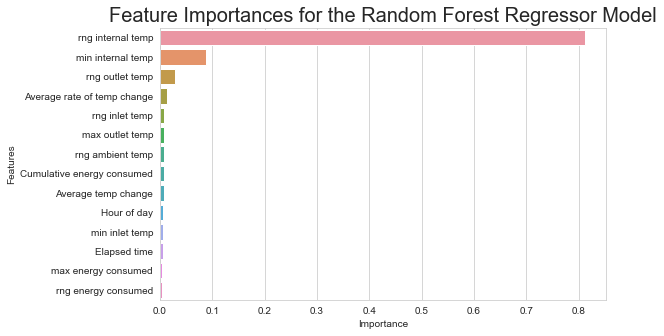

In [55]:
fig = plt.figure(figsize = (8,5))
feature_names = [key for key in df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)]
feat_imps = list(zip(feature_names,rforest_m.feature_importances_))
feats, imps = zip(*(sorted(list(filter(lambda x:x[1] != 0, feat_imps)), key=lambda x:x[1],reverse=True)))
ax = sns.barplot(x = list(imps[:]), y = list(feats[:]))
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
ax.set_title("Feature Importances for the Random Forest Regressor Model",fontsize=20)

In [56]:
print("Top 5 features from the Vanilla Random Forest model \n")
for i in list(feats[:5]):
    print(i)

Top 5 features from the Vanilla Random Forest model 

rng internal temp
min internal temp
rng outlet temp
Average rate of temp change
rng inlet temp


In [57]:
# Hyperparameter tune the Random forest model

In [58]:
# # parameters
# criterion = ["squared_error", "absolute_error", "poisson"]
# max_features = [0.3,0.4,0.5,0.8,1.0]
# max_depth = [2,5,10,15,None]

# train_scores = []
# val_scores = []

# tscv = TimeSeriesSplit(n_splits = 4)

# for criteria in criterion:
#     for feature in max_features:
#         for depth in max_depth:
#             cv_scores = []
#             for train_index, val_index in tscv.split(df_final):
#                 cv_train, cv_val = df_final.iloc[train_index], df_final.iloc[val_index]
#                 X_train = cv_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
#                 y_train = cv_train['Cumulative volume of water drawn']
#                 X_val = cv_val.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
#                 y_val = cv_val['Cumulative volume of water drawn']
#                 model = RandomForestRegressor(random_state=42, oob_score=True, warm_start=True, \
#                                                criterion=criteria, max_features = feature, max_depth = depth)

#                 model.fit(X_train,y_train)
#                 y_pred_rforest_val= model.predict(X_val)
#                 cv_scores.append(mean_squared_error(y_val,y_pred_rforest_val))
#             val_scores.append(((criteria,feature,depth),np.mean(cv_scores)))


                                  
                            

In [59]:
# hyperparameter tuning
criterion = ["squared_error", "absolute_error", "poisson"]
max_features = [0.3,0.4,0.5,0.8,1.0]
max_depth = [2,5,10,15,None]

val_scores = []

for criteria in criterion:
    for feature in max_features:
        for depth in max_depth:
            model = RandomForestRegressor(random_state=42, oob_score=True, warm_start=True, \
                                           criterion=criteria, max_features = feature, max_depth = depth)
            model.fit(X_train,y_train)
            y_pred_rforest_val= model.predict(X_val)
            val_scores.append(((criteria,feature,depth),mean_squared_error(y_val,y_pred_rforest_val)))            

In [60]:
val_scores.sort(key=lambda y: y[1])
best_criterion = val_scores[0][0][0]
best_max_features = val_scores[0][0][1]
best_max_depth = val_scores[0][0][2]

print(f"The best Random Forest Regressor validation MSE is:{val_scores[0][1]}")
print(f"The best Criterion is :{best_criterion}")
print(f"The best max_features is:{best_max_features}")
print(f"The best max_depth is:{best_max_depth}")

rf_best = RandomForestRegressor(random_state=42, criterion=best_criterion, \
                                max_features = best_max_features, max_depth = best_max_depth)
rf_best.fit(X_train,y_train)
y_pred_rforestb_train = rf_best.predict(X_train)
y_pred_rforestb_val= rf_best.predict(X_val)

print(f"Mean-squared error on Training set (Random Forest, all features): {mean_squared_error(y_train,y_pred_rforestb_train)}")
print(f"Mean-squared error on Validation set (Random Forest, all features): {mean_squared_error(y_val,y_pred_rforestb_val)}")
vanillaRF_MSE_val_tuned = mean_squared_error(y_val,y_pred_rforestb_val)
rforestb_R2 = rf_best.score(X_val, y_val)
n = len(X_train)
p = len(X_train[0])
rforestb_adj_R2 = 1- ((1-rforestb_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (Random Forest, all features): {round(rforestb_adj_R2,3)}")

The best Random Forest Regressor validation MSE is:2444.2646363579142
The best Criterion is :squared_error
The best max_features is:0.5
The best max_depth is:15
Mean-squared error on Training set (Random Forest, all features): 414.77175039170805
Mean-squared error on Validation set (Random Forest, all features): 2444.2646363579142
Adjusted R^2 score on Validation set (Random Forest, all features): 0.909


Text(0.5, 1.0, 'Feature Importances for the Random Forest Regressor Model')

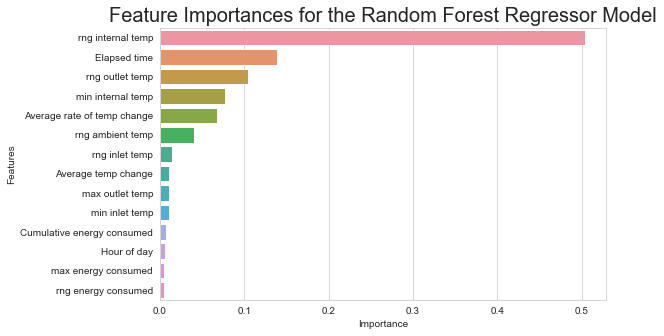

In [61]:
fig = plt.figure(figsize = (8,5))
feature_names = [key for key in df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)]
feat_imps = list(zip(feature_names,rf_best.feature_importances_))
feats, imps = zip(*(sorted(list(filter(lambda x:x[1] != 0, feat_imps)), key=lambda x:x[1],reverse=True)))
ax = sns.barplot(x = list(imps[:]), y = list(feats[:]))
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
ax.set_title("Feature Importances for the Random Forest Regressor Model",fontsize=20)

In [62]:
MSE_pct_decrease = round(((vanillaRF_MSE_val - vanillaRF_MSE_val_tuned) / vanillaRF_MSE_val) * 100,2)
print(f"Percentage decrease in validation mean squared error after hyperparameter tuning: {MSE_pct_decrease}%")

Percentage decrease in validation mean squared error after hyperparameter tuning: 14.72%


Now, let's hyperparameter tune the random forest regressor model using only **the top 5 features from the lasso regression model** as the independent variables. 

In [63]:
[list(coeffecients.sort_values(by='Coefficient', key=abs,ascending=False).index[1:6])]

[['Bias Term',
  'rng outlet temp',
  'rng ambient temp',
  'rng inlet temp',
  'min internal temp']]

In [64]:
# hyperparameter tuning using the top 5 features from the lasso regression model only
criterion = ["squared_error", "absolute_error", "poisson"]
max_features = [0.3,0.4,0.5,0.8,1.0]
max_depth = [2,5,10,15,None]

X_train_5 = df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)[top_5coeff_lasso]
X_val_5 = df_val.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)[top_5coeff_lasso]

val_scores = []

for criteria in criterion:
    for feature in max_features:
        for depth in max_depth:
            model = RandomForestRegressor(random_state=42, oob_score=True, warm_start=True, \
                                           criterion=criteria, max_features = feature, max_depth = depth)
            model.fit(X_train_5,y_train)
            y_pred_rforest_val5= model.predict(X_val_5)
            val_scores.append(((criteria,feature,depth),mean_squared_error(y_val,y_pred_rforest_val5)))            
            


In [65]:
val_scores.sort(key=lambda y: y[1])
best_criterion = val_scores[0][0][0]
best_max_features = val_scores[0][0][1]
best_max_depth = val_scores[0][0][2]
print(f"The best Random Forest Regressor validation MSE is:{val_scores[0][1]}")
print(f"The best Criterion is :{best_criterion}")
print(f"The best max_features is:{best_max_features}")
print(f"The best max_depth is:{best_max_depth}")

rf_best5 = RandomForestRegressor(random_state=42, criterion=best_criterion, \
                                max_features = best_max_features, max_depth = best_max_depth)
rf_best5.fit(X_train_5,y_train)
y_pred_rforestb5_train = rf_best5.predict(X_train_5)
y_pred_rforestb5_val= rf_best5.predict(X_val_5)

print(f"Mean-squared error on Training set, (Random Forest, top 5 features lasso): {mean_squared_error(y_train,y_pred_rforestb5_train)}")
print(f"Mean-squared error on Validation set, (Random Forest, top 5 features lasso): {mean_squared_error(y_val,y_pred_rforestb5_val)}")
lassoRF_MSE_val = mean_squared_error(y_val,y_pred_rforestb5_val)
rforestb5_R2 = rf_best5.score(X_val_5, y_val)
n = len(X_train)
p = 5
rforestb5_adj_R2 = 1- ((1-rforestb5_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (Random Forest, top 5 features lasso): {round(rforestb5_adj_R2,3)}")

The best Random Forest Regressor validation MSE is:2719.7247848915986
The best Criterion is :absolute_error
The best max_features is:0.4
The best max_depth is:15
Mean-squared error on Training set, (Random Forest, top 5 features lasso): 714.7215167062416
Mean-squared error on Validation set, (Random Forest, top 5 features lasso): 2719.7247848915986
Adjusted R^2 score on Validation set (Random Forest, top 5 features lasso): 0.899


In [66]:
MSE_pct_decrease = round(((vanillaRF_MSE_val - lassoRF_MSE_val) / vanillaRF_MSE_val) * 100,2)
print(f"Percentage decrease in validation mean squared error after hyperparameter tuning, (Random Forest, top 5 features lasso):\n {MSE_pct_decrease}%")

Percentage decrease in validation mean squared error after hyperparameter tuning, (Random Forest, top 5 features lasso):
 5.1%


Now, let's hyperparameter tune the random forest regressor model using only **the top 5 features from the vanilla Random Forest model** as the independent variables. 

In [67]:
# hyperparameter tuning using the top 5 features from the vailla random forest model 
criterion = ["squared_error", "absolute_error", "poisson"]
max_features = [0.3,0.4,0.5,0.8,1.0]
max_depth = [2,5,10,15,None]

X_train_RF5 = df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)[list(feats[:5])]
X_val_RF5 = df_val.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)[list(feats[:5])]

val_scores = []

for criteria in criterion:
    for feature in max_features:
        for depth in max_depth:
            model = RandomForestRegressor(random_state=42, oob_score=True, warm_start=True, \
                                           criterion=criteria, max_features = feature, max_depth = depth)
            model.fit(X_train_RF5,y_train)
            y_pred_rforest_valRF5= model.predict(X_val_RF5)
            val_scores.append(((criteria,feature,depth),mean_squared_error(y_val,y_pred_rforest_valRF5)))            

In [68]:
val_scores.sort(key=lambda y: y[1])
best_criterion = val_scores[0][0][0]
best_max_features = val_scores[0][0][1]
best_max_depth = val_scores[0][0][2]
print(f"The best Random Forest Regressor validation MSE is:{val_scores[0][1]}")
print(f"The best Criterion is :{best_criterion}")
print(f"The best max_features is:{best_max_features}")
print(f"The best max_depth is:{best_max_depth}")

rf_best_5 = RandomForestRegressor(random_state=42, criterion=best_criterion, \
                                max_features = best_max_features, max_depth = best_max_depth)
rf_best_5.fit(X_train_RF5,y_train)
y_pred_rforestbRF5_train = rf_best_5.predict(X_train_RF5)
y_pred_rforestbRF5_val= rf_best_5.predict(X_val_RF5)

print(f"Mean-squared error on Training set, (Random Forest, top 5 features RF): {mean_squared_error(y_train,y_pred_rforestbRF5_train)}")
print(f"Mean-squared error on Validation set, (Random Forest, top 5 features RF): {mean_squared_error(y_val,y_pred_rforestbRF5_val)}")
top5RF_MSE_val = mean_squared_error(y_val,y_pred_rforestbRF5_val)
rforestb5rf_R2 = rf_best_5.score(X_val_RF5, y_val)
n = len(X_train)
p = 5
rforestb5rf_adj_R2 = 1- ((1-rforestb5rf_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (Random Forest, top 5 features RF): {round(rforestb5rf_adj_R2,3)}")

The best Random Forest Regressor validation MSE is:2893.888362171221
The best Criterion is :squared_error
The best max_features is:0.4
The best max_depth is:15
Mean-squared error on Training set, (Random Forest, top 5 features RF): 488.2441269366004
Mean-squared error on Validation set, (Random Forest, top 5 features RF): 2893.888362171221
Adjusted R^2 score on Validation set (Random Forest, top 5 features RF): 0.893


In [69]:
MSE_pct_decrease = round(((vanillaRF_MSE_val - top5RF_MSE_val) / vanillaRF_MSE_val) * 100,2)
print(f"Percentage decrease in validation mean squared error after hyperparameter tuning, (Random Forest, top 5 features): {MSE_pct_decrease}%")

Percentage decrease in validation mean squared error after hyperparameter tuning, (Random Forest, top 5 features): -0.97%


## Ridge Regression

In [70]:
ridgereg_m = linear_model.Ridge()
ridgereg_m.fit(X_train, y_train)
y_pred_ridge_val=ridgereg_m.predict(X_val)
y_pred_ridge_train = ridgereg_m.predict(X_train)

print(f"Mean-squared error on Training set: {mean_squared_error(y_train,y_pred_ridge_train)}")
print(f"Mean-squared error on Validation set: {mean_squared_error(y_val,y_pred_ridge_val)}")
vanilla_Ridge_MSE_val = mean_squared_error(y_val,y_pred_ridge_val)

Mean-squared error on Training set: 3822.0373085405718
Mean-squared error on Validation set: 3554.0554495646584


Hyperparameter tuning the L2 regularization term 

In [71]:
val_scores = []

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 3)

alphas = np.linspace(0.01,20,1000)
for alpha_val in alphas:
    cv_scores = []
    for train_index, val_index in tscv.split(df_final):
        cv_train, cv_val = df_final.iloc[train_index], df_final.iloc[val_index]
        X_cv_train = cv_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
        y_cv_train = cv_train['Cumulative volume of water drawn']
        X_cv_val = cv_val.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
        y_cv_val = cv_val['Cumulative volume of water drawn']
        lassoreg_m = linear_model.Ridge(alpha=alpha_val)
        lassoreg_m.fit(X_cv_train, y_cv_train)
        y_pred_lasso_val=lassoreg_m.predict(X_cv_val)
        cv_scores.append(mean_squared_error(y_cv_val,y_pred_lasso_val))
    val_scores.append((alpha_val,np.mean(cv_scores)))

In [72]:
val_scores.sort(key = lambda y:y[1])
print(f"The optimal alpha value is: {round(val_scores[0][0],2)}")

ridgereg_best = linear_model.Ridge(alpha=val_scores[0][0])
ridgereg_best.fit(X_train, y_train)
y_pred_ridge_val=ridgereg_best.predict(X_val)
y_pred_ridge_train = ridgereg_best.predict(X_train)
print(f"The optimal Mean-squared error on Validation set (Ridge Regression): {round(mean_squared_error(y_val,y_pred_ridge_val),2)}")
Ridge_MSE_val = mean_squared_error(y_val,y_pred_ridge_val)
ridgereg_R2 = ridgereg_best.score(X_val, y_val)
n = len(X_train)
p = len(X_train[0])
ridgereg_adj_R2 = 1- ((1-ridgereg_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (Ridge Regression): {round(ridgereg_adj_R2,3)}")

The optimal alpha value is: 20.0
The optimal Mean-squared error on Validation set (Ridge Regression): 3531.47
Adjusted R^2 score on Validation set (Ridge Regression): 0.869


In [73]:
MSE_pct_decrease = round(((vanilla_Ridge_MSE_val - Ridge_MSE_val) / vanilla_Ridge_MSE_val) * 100,2)
print(f"Percentage decrease in validation mean squared error after hyperparameter tuning, (Ridge Regression): {MSE_pct_decrease}%")

Percentage decrease in validation mean squared error after hyperparameter tuning, (Ridge Regression): 0.64%


# Boosting

In [74]:
from xgboost import XGBRegressor

In [75]:
XGB = XGBRegressor(random_state=42)
XGB.fit(X_train, y_train)
y_pred_XGB_train = XGB.predict(X_train)
y_pred_XGB_val= XGB.predict(X_val)

print(f"Mean-squared error on Training set (XGBoost): {mean_squared_error(y_train,y_pred_XGB_train)}")
print(f"Mean-squared error on Validation set (XGBoost): {mean_squared_error(y_val,y_pred_XGB_val)}")
XGB_MSE_val = mean_squared_error(y_val,y_pred_XGB_val)
XGB_R2 = XGB.score(X_val, y_val)
n = len(X_train)
p = len(X_train[0])
XGB_adj_R2 = 1- ((1-XGB_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (XGBoost): {round(XGB_adj_R2,3)}")

Mean-squared error on Training set (XGBoost): 8.878579425528189
Mean-squared error on Validation set (XGBoost): 3236.069961402865
Adjusted R^2 score on Validation set (XGBoost): 0.88


In [76]:
# hyperparameter tuning
n_estimators = [25,50,100,200]
reg_lambda = [0.5,1,1.5,2]
learning_rate = [0.1,0.2,0.3,0.5]
reg_alpha = [0,0.25,0.5,0.75,1]

val_scores = []

for estimator in n_estimators:
    for l2 in reg_lambda:
        for l_rate in learning_rate:
            for l1 in reg_alpha:
                model = XGBRegressor(random_state=42, warm_start=True, \
                                    n_estimators=estimator, reg_lambda = l2, learning_rate = l_rate,reg_alpha=l1)
                model.fit(X_train,y_train)
                y_pred_XGB_val_cv= model.predict(X_val)
                val_scores.append(((estimator,l2,l_rate,l1),mean_squared_error(y_val,y_pred_XGB_val_cv)))            

[21:14:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:23] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:24] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:24] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:24] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:28] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:28] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:28] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:34] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:34] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:34] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:40] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:41] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:41] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:46] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:47] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:47] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:53] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:53] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:53] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:14:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:15:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:15:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:15:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:15:20] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:15:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:15:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[21:15:32] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:15:33] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:15:33] WARNING: ..\src\learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

In [77]:
val_scores.sort(key=lambda y: y[1])
best_n_estimators = val_scores[0][0][0]
best_reg_lambda = val_scores[0][0][1]
best_learning_rate = val_scores[0][0][2]
best_reg_alpha = val_scores[0][0][3]
print(f"The best XGBoostRegressor validation MSE is:{val_scores[0][1]}")
print(f"The best n_estimators is :{best_n_estimators}")
print(f"The best reg_lambda is:{best_reg_lambda}")
print(f"The best learning_rate is:{best_learning_rate}")
print(f"The best reg_alpha is:{best_reg_alpha}")

XGB_best = XGBRegressor(random_state=42, n_estimators=best_n_estimators, reg_lambda = best_reg_lambda, \
                       learning_rate = best_learning_rate, reg_alpha=best_reg_alpha)
XGB_best.fit(X_train,y_train)
y_pred_XGBb_train = XGB_best.predict(X_train)
y_pred_XGBb_val= XGB_best.predict(X_val)

print(f"Mean-squared error on Training set (XGBoost): {mean_squared_error(y_train,y_pred_XGBb_train)}")
print(f"Mean-squared error on Validation set (XGBoost): {mean_squared_error(y_val,y_pred_XGBb_val)}")
tunedXGB_MSE_val = mean_squared_error(y_val,y_pred_XGBb_val)
XGB_best_R2 = XGB_best.score(X_val, y_val)
n = len(X_train)
p = len(X_train[0])
XGB_best_adj_R2 = 1- ((1-XGB_best_R2) * (n-1)/(n-p-1))
print(f"Adjusted R^2 score on Validation set (XGBoost): {round(XGB_best_adj_R2,3)}")


The best XGBoostRegressor validation MSE is:2677.8298728677937
The best n_estimators is :200
The best reg_lambda is:1.5
The best learning_rate is:0.1
The best reg_alpha is:0.5
Mean-squared error on Training set (XGBoost): 34.33259940941083
Mean-squared error on Validation set (XGBoost): 2677.8298728677937
Adjusted R^2 score on Validation set (XGBoost): 0.9


In [78]:
MSE_pct_decrease = round(((XGB_MSE_val - tunedXGB_MSE_val) / XGB_MSE_val) * 100,2)
print(f"Percentage decrease in validation mean squared error after hyperparameter tuning (XGBoost): {MSE_pct_decrease}%")

Percentage decrease in validation mean squared error after hyperparameter tuning (XGBoost): 17.25%


Text(0.5, 1.0, 'Feature Importances for the XGBoost Regressor Model')

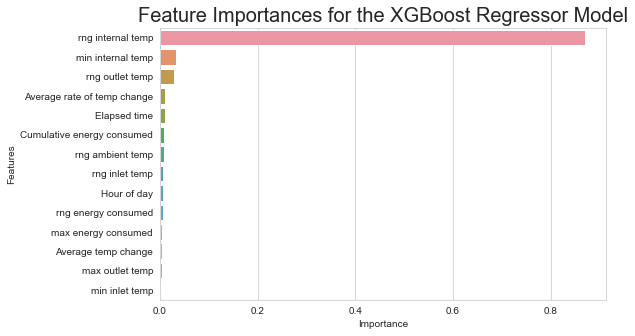

In [79]:
fig = plt.figure(figsize = (8,5))
feature_names = [key for key in df_train.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)]
feat_imps = list(zip(feature_names,XGB_best.feature_importances_))
feats, imps = zip(*(sorted(list(filter(lambda x:x[1] != 0, feat_imps)), key=lambda x:x[1],reverse=True)))
ax = sns.barplot(x = list(imps[:]), y = list(feats[:]))
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
ax.set_title("Feature Importances for the XGBoost Regressor Model",fontsize=20)

# Model Evaluation on Validation dataset

In [80]:
cols = ["Validation Mean Squared Error", "Validation Adjusted R^2 Score"]
models = ['Baseline Model','Linear Regression','Lasso Regression','Ridge Regression', 'Vanilla Random Forest', \
          'Random Forest (Lasso Feature Selection)','Random Forest (RF Feature Selection)','XGBoostRegressor']
MSE_array = np.array([baseline_MSE_val, linreg_MSE_val, lassoreg_MSE_val, Ridge_MSE_val,vanillaRF_MSE_val_tuned,lassoRF_MSE_val,top5RF_MSE_val,tunedXGB_MSE_val])
adj_R2_array = np.array([0,linreg_adj_R2, lassoreg_adj_R2, ridgereg_adj_R2, rforestb_adj_R2, rforestb5_adj_R2, rforestb5rf_adj_R2, XGB_best_adj_R2])
data_dict = {"Validation Mean Squared Error":MSE_array,"Validation Adjusted R^2 Score":adj_R2_array}

In [81]:
Results = pd.DataFrame(data = data_dict, columns = cols, index = models)
Results_f = Results.round(2).sort_values(by="Validation Mean Squared Error",ascending=True)
Results_f

,Validation Mean Squared Error,Validation Adjusted R^2 Score
Vanilla Random Forest,2444.26,0.91
XGBoostRegressor,2677.83,0.90
Random Forest (Lasso Feature Selection),2719.72,0.90
Random Forest (RF Feature Selection),2893.89,0.89
Lasso Regression,3519.56,0.87
Ridge Regression,3531.47,0.87
Linear Regression,3544.83,0.87
Baseline Model,27153.04,0.00


In [82]:
print(f"The optimal model is: {Results_f.index[0]}")
print(f"The optimal validation mean squared error is: {Results_f['Validation Mean Squared Error'][0]}")
print(f"The optimal validation adjusted R^2 Score is: {Results_f['Validation Adjusted R^2 Score'][0]}")

The optimal model is: Vanilla Random Forest
The optimal validation mean squared error is: 2444.26
The optimal validation adjusted R^2 Score is: 0.91


# Forecast on Validation dataset using the Optimal Model

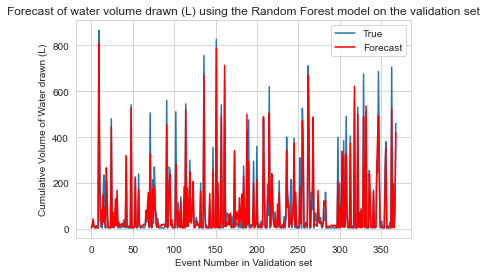

In [83]:
from matplotlib import pyplot
plt.plot(y_val.values, label = "True")
plt.plot(y_pred_rforestb_val,color='red', label = "Forecast")
plt.xlabel("Event Number in Validation set")
plt.ylabel("Cumulative Volume of Water drawn (L)")
plt.title("Forecast of water volume drawn (L) using the Random Forest model on the validation set",fontsize=12)
plt.legend(loc="best")
pyplot.show()

# Optimal Model Training

Now that we have our final model, we will train this model on the entire development dataset (training set + validation set).
Following this, the model will be evaluated on the training dataset. 

In [84]:
X_dev = df_final.drop(['Event start time','Event end time','Cumulative volume of water drawn'],axis=1)
y_dev = df_final['Cumulative volume of water drawn']

In [85]:
ss_dev = StandardScaler()
X_dev = ss_dev.fit_transform(X_dev)

In [86]:
rf_best.fit(X_dev,y_dev)

RandomForestRegressor(max_depth=15, max_features=0.5, random_state=42)

# Model Deployment on Test set

In [87]:
geyser_test = pd.read_csv('geyser_test_set.csv')

In [88]:
def preprocess(df):    
    # Convert time_index feature from a string to a datetime object 
    df['time_index'] = pd.to_datetime(df['time_index'])
    # df_cont is a dataframe with rows only where Water flow is True
    df_cont = (df[df['Water flow'] == True])
    df_cont['Block Number'] = df_cont.index.to_series().diff().ne(1).cumsum()
    df_final = df_cont.groupby('Block Number').mean()
    
    df_final['Cumulative energy consumed'] = df_cont.groupby('Block Number').sum()['Energy consumed']
#     df_final['Cumulative volume of water drawn'] = df_cont.groupby('Block Number').sum()['Volume of water drawn']
    df_final.rename(columns={'Internal temperature': 'Average internal temperature',
                        'Inlet temperature': 'Average inlet temperature',
                        'Outlet temperature': 'Average outlet temperature',
                        'Ambient temperature':'Average ambient temperature',
                        'Energy consumed':'Average energy consumed',
                        'Volume of water drawn':'Average volume of water drawn'}, inplace=True)
#     df_final = df_final.drop('Average volume of water drawn',axis=1)

    df_final['min internal temp'] = df_cont.groupby('Block Number').min()['Internal temperature']
    df_final['min inlet temp'] = df_cont.groupby('Block Number').min()['Inlet temperature']
    df_final['min outlet temp'] = df_cont.groupby('Block Number').min()['Outlet temperature']
    df_final['min ambient temp'] = df_cont.groupby('Block Number').min()['Ambient temperature']
    df_final['min energy consumed'] = df_cont.groupby('Block Number').min()['Energy consumed']

    df_final['max internal temp'] = df_cont.groupby('Block Number').max()['Internal temperature']
    df_final['max inlet temp'] = df_cont.groupby('Block Number').max()['Inlet temperature']
    df_final['max outlet temp'] = df_cont.groupby('Block Number').max()['Outlet temperature']
    df_final['max ambient temp'] = df_cont.groupby('Block Number').max()['Ambient temperature']
    df_final['max energy consumed'] = df_cont.groupby('Block Number').max()['Energy consumed']

#     df_final['std internal temp'] = df_cont.groupby('Block Number').std()['Internal temperature']
#     df_final['std inlet temp'] = df_cont.groupby('Block Number').std()['Inlet temperature']
#     df_final['std outlet temp'] = df_cont.groupby('Block Number').std()['Outlet temperature']
#     df_final['std ambient temp'] = df_cont.groupby('Block Number').std()['Ambient temperature']
#     df_final['std energy consumed'] = df_cont.groupby('Block Number').std()['Energy consumed']

    df_final['rng internal temp'] = df_final['max internal temp'] - df_final['min internal temp']
    df_final['rng inlet temp'] = df_final['max inlet temp'] - df_final['min inlet temp']
    df_final['rng outlet temp'] = df_final['max outlet temp'] - df_final['min outlet temp']
    df_final['rng ambient temp'] = df_final['max ambient temp'] - df_final['min ambient temp']
    df_final['rng energy consumed'] = df_final['max energy consumed'] - df_final['min energy consumed']

    df_final['number of recordings'] = df_cont.groupby('Block Number').size().values

    

    df_final['Event start time'] = df_cont[df_cont.index.to_series().diff().ne(1) == True]['time_index'].to_frame().reset_index().set_index(df_final.index)['time_index']
    event_start_index = df_cont[df_cont.index.to_series().diff().ne(1) == True].index
    event_end_index = []
    for idx in event_start_index:
        if idx == event_start_index[0]:
            continue
        itemindex = np.where(df_cont.index == idx)
        event_end_index.append(df_cont.index[itemindex[0][0]-1])
    event_end_index.append(df_cont.index[-1])
    df_final['Event end time'] = df_cont.loc[event_end_index]['time_index'].to_frame().reset_index().set_index(df_final.index)['time_index']

    t = (df_final['Event end time'] - df_final['Event start time']) + timedelta(minutes=5)
    Elapsed_time = []
    for time in t:
        Elapsed_time.append(time.total_seconds() / 3600)

    df_final['Elapsed time'] = Elapsed_time
    df_final['Power'] = df_final['Cumulative energy consumed'] / df_final['Elapsed time']

    df_final['Hour of day'] = df_final['Event start time'].apply(lambda x:x.hour)
    df_final['Day of event'] = df_final['Event start time'].apply(lambda x:x.day)
    df_final['Month of event'] = df_final['Event start time'].apply(lambda x:x.month)
    df_final['Average temp change'] = df_final['Average outlet temperature'] - df_final['Average inlet temperature']
    df_final['Average rate of temp change'] = df_final['Average temp change'] / df_final['Elapsed time']
    df_final = df_final.drop(corr_features,axis = 1)
    df_final = df_final.drop(['Day of event','Month of event'],axis=1)
    return df_final


In [89]:
df_test = preprocess(geyser_test)

In [90]:
# Preprocess the data
df_test = preprocess(geyser_test)
# Prepare feature matrix (drop non-numerical and scale)
X_test = df_test.drop(['Event start time','Event end time'],axis=1)
X_test = ss_dev.transform(X_test)
# Use model to forecast water volume drawn
df_test['Forecast water volume drawn (L)'] = rf_best.predict(X_test)
df_test = df_test.set_index(df_test.index.rename('Event Number'))
# Prepare results in appropriate format
df_result = df_test[['Event start time','Forecast water volume drawn (L)']]
df_result['Event start time'] = df_result['Event start time'].dt.strftime('%d/%m/%Y %H:%M:%S')
df_result

,Event start time,Forecast water volume drawn (L)
Event Number,,
1,01/02/2021 07:58:21,6.981151
2,01/02/2021 08:28:21,236.751250
3,01/02/2021 08:58:21,153.190788
4,01/02/2021 10:03:22,96.249011
5,01/02/2021 10:38:24,11.279633
...,...,...
132,10/02/2021 12:23:21,614.156818
133,10/02/2021 14:43:21,15.454846
134,10/02/2021 15:18:23,22.321019


In [91]:
df_result['Forecast water volume drawn (L)'].mean()

96.92212867255664

In [92]:
df_result.to_csv('BA_Final_Project_Test_Forecast.csv', index=False)

# THE END